# Capstone Project
## Import necessary Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 112kB 22.4MB/s eta 0:00:01
Libraries imported.


## Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = 'Hidden for Github' # your Foursquare ID
CLIENT_SECRET = 'Hidden for Github' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Hidden for GithubCLIENT_SECRET:Hidden for Github


## 1. Download data related to New York boroughs and neighborhoods 
New York has a total of 5 boroughs and 306 neighborhoods. A dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighborhood is needed. This data is available here: https://geo.nyu.edu/catalog/nyu_2451_34572

A file downloaded to the server was used.

In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


**Load the data**

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

**Tranform the data into a pandas dataframe**

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

*Loop through the data and fill the dataframe one row at a time.*

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
print('\nThe dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)
neighborhoods.head()


The dataframe has 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 2. Covid Data
Download the percent of people who tested Covid positive, by ZIP code from the website: https://www1.nyc.gov/site/doh/covid/covid-19-data.page#epicurve
The data for November 15-21, 2020 has been downloaded and placed in GitHub (https://github.com/alokanant/Coursera_Capstone/blob/master/data/Covid-data-8UcZR.csv) for use.

The data also show the rate of people tested during the most recent seven days. A neighborhood is considered to have adequate testing when at least 260 residents per 100,000 have been tested in the past week. 

In [8]:
#read test results info from CSV file
filename = 'https://github.com/alokanant/Coursera_Capstone/blob/master/data/Covid-data-8UcZR.csv?raw=true'
df_Covid = pd.read_csv(filename)
df_Covid.head()

,ZIP,Neighborhood,7-day percent positive,People tested,New people positive,"Median daily test rate<br>(per 100,000)",Adequate testing sample?,Date range
0,10001,Chelsea/NoMad/West Chelsea,2.19,1326,29,861.9,Yes,November 15-November 21
1,10002,Chinatown/Lower East Side,2.33,2876,67,673.1,Yes,November 15-November 21
2,10003,East Village/Gramercy/Greenwich Village,1.23,5305,65,1973.0,Yes,November 15-November 21
3,10004,Financial District,2.34,299,7,1648.7,Yes,November 15-November 21
4,10005,Financial District,0.48,414,2,753.7,Yes,November 15-November 21


In [9]:
#decompress the neighborhoods
df_Covid['Neighborhood'] = df_Covid['Neighborhood'].str.split('/')
df_Covid = df_Covid.explode('Neighborhood', ignore_index=True)
df_Covid.head()

,ZIP,Neighborhood,7-day percent positive,People tested,New people positive,"Median daily test rate<br>(per 100,000)",Adequate testing sample?,Date range
0,10001,Chelsea,2.19,1326,29,861.9,Yes,November 15-November 21
1,10001,NoMad,2.19,1326,29,861.9,Yes,November 15-November 21
2,10001,West Chelsea,2.19,1326,29,861.9,Yes,November 15-November 21
3,10002,Chinatown,2.33,2876,67,673.1,Yes,November 15-November 21
4,10002,Lower East Side,2.33,2876,67,673.1,Yes,November 15-November 21


In [10]:
df_Covid.drop('Date range', 1, inplace=True) #drop Date range column, it is the same for all records
#name the columns better
df_Covid.rename(columns={'7-day percent positive':'Pos-percent-7d', 'People tested' : 'NumTested', 'New people positive': 'NewPos', 'Median daily test rate<br>(per 100,000)' : 'DailyMedianTest-per100k', 'Adequate testing sample?' : 'AdeqSample'}, inplace=True)
df_Covid.head()

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample
0,10001,Chelsea,2.19,1326,29,861.9,Yes
1,10001,NoMad,2.19,1326,29,861.9,Yes
2,10001,West Chelsea,2.19,1326,29,861.9,Yes
3,10002,Chinatown,2.33,2876,67,673.1,Yes
4,10002,Lower East Side,2.33,2876,67,673.1,Yes


In [11]:
#drop rows with adequate sample = No
row_ids = df_Covid[df_Covid.AdeqSample != 'Yes'].index
print ('Indices of rows with inadequate sample: ' + str(row_ids))
#Drop these
df_Covid.drop(row_ids, inplace=True)
df_Covid.reset_index(drop=True, inplace=True)

Indices of rows with inadequate sample: Int64Index([169, 259, 260, 261, 262, 263], dtype='int64')


Add latitude, longitude, borough info

In [12]:
df_Covid = pd.merge(df_Covid, neighborhoods, on="Neighborhood", how="inner")
df_Covid.head()

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude
0,10001,Chelsea,2.19,1326,29,861.9,Yes,Manhattan,40.744035,-74.003116
1,10001,Chelsea,2.19,1326,29,861.9,Yes,Staten Island,40.594726,-74.189560
2,10011,Chelsea,1.38,3340,46,1300.6,Yes,Manhattan,40.744035,-74.003116
3,10011,Chelsea,1.38,3340,46,1300.6,Yes,Staten Island,40.594726,-74.189560
4,10002,Chinatown,2.33,2876,67,673.1,Yes,Manhattan,40.715618,-73.994279


In [13]:
print('There are {} test data records for November 15-21.'.format(len(df_Covid)))
print('There are {} neighborhoods with 5% or more 7-day percent positive'.format(len(df_Covid[df_Covid['Pos-percent-7d'] >= 5])))
print('There are {} neighborhoods with 1.5% or less 7-day percent positive'.format(len(df_Covid[df_Covid['Pos-percent-7d'] <= 1.5])))

There are 260 test data records for November 15-21.
There are 31 neighborhoods with 5% or more 7-day percent positive
There are 43 neighborhoods with 1.5% or less 7-day percent positive


In [14]:
#get the rows with percent positive >= 5% 
df_nMaxNewPos = df_Covid.nlargest(31, 'Pos-percent-7d')
df_nMaxNewPos.head()

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude
67,10308,Great Kills,7.42,1064,79,583.5,Yes,Staten Island,40.549480,-74.149324
259,11697,Breezy Point,7.14,336,24,1414.8,Yes,Queens,40.557401,-73.925512
78,10452,Concourse,6.37,1900,121,380.3,Yes,Bronx,40.834284,-73.915589
240,11421,Woodhaven,6.30,1080,68,379.5,Yes,Queens,40.689887,-73.858110
58,10306,New Dorp,6.28,2102,132,668.5,Yes,Staten Island,40.572572,-74.116479


In [15]:
#get the rows with with percent positive <= 1.5%  
df_nLeastNewPos = df_Covid.nsmallest(43, 'Pos-percent-7d')
df_nLeastNewPos.head()

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude
48,10044,Roosevelt Island,0.27,364,1,565.5,Yes,Manhattan,40.762160,-73.949168
14,10005,Financial District,0.48,414,2,753.7,Yes,Manhattan,40.707107,-74.010665
27,10065,Lenox Hill,0.63,1912,12,1236.6,Yes,Manhattan,40.768113,-73.958860
31,10065,Upper East Side,0.63,1912,12,1236.6,Yes,Manhattan,40.775639,-73.960508
12,10012,Greenwich Village,0.89,2139,19,1848.6,Yes,Manhattan,40.726933,-73.999914


## 3. Neighbourhoods with high and low positivity rate

### Use geopy library to get the latitude and longitude values of New York City.
In order to define an instance of the geocoder *ny_explorer* user_agent is defined.

In [16]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with top 31 and least 43 neighborhoods superimposed on top.

In [17]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add max pos markers to map
for lat, lng, borough, neighborhood in zip(df_nMaxNewPos['Latitude'], df_nMaxNewPos['Longitude'], df_nMaxNewPos['Borough'], df_nMaxNewPos['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  

# add least pos markers to map
for lat, lng, borough, neighborhood in zip(df_nLeastNewPos['Latitude'], df_nLeastNewPos['Longitude'], df_nLeastNewPos['Borough'], df_nLeastNewPos['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork) 
    
map_newyork

## START - Not used for report
### Compare neighborhoods with topmost and least positive rates

Add parameters to identify top 10 and least 10 cases

In [18]:
df_nMaxNewPos['LocationCategory'] = '7-day pos >= 5%'
df_nLeastNewPos['LocationCategory'] = '7-day pos <= 1.5%'

Get parameters of neighborhood with max/least new positive cases.

In [19]:
top_Nbr = df_nMaxNewPos.iloc[df_nMaxNewPos['NewPos'].argmax()]['Neighborhood']
top_Lat = df_nMaxNewPos.iloc[df_nMaxNewPos['NewPos'].argmax()]['Latitude']
top_Long = df_nMaxNewPos.iloc[df_nMaxNewPos['NewPos'].argmax()]['Longitude']
top_Cases = df_nMaxNewPos.iloc[df_nMaxNewPos['NewPos'].argmax()]['NewPos']
print('Neighborhood with max new positive cases (' + str(top_Cases) + ') is ' + top_Nbr + ' with Lat=' + str(top_Lat) + ' and Long=' + str(top_Long) )

least_Nbr = df_nLeastNewPos.iloc[df_nLeastNewPos['NewPos'].argmin()]['Neighborhood']
least_Lat = df_nLeastNewPos.iloc[df_nLeastNewPos['NewPos'].argmin()]['Latitude']
least_Long = df_nLeastNewPos.iloc[df_nLeastNewPos['NewPos'].argmin()]['Longitude']
least_Cases = df_nLeastNewPos.iloc[df_nLeastNewPos['NewPos'].argmin()]['NewPos']
print('Neighborhood with least new positive cases (' + str(least_Cases) + ') is ' + least_Nbr + ' with Lat=' + str(least_Lat) + ' and Long=' + str(least_Long) )


Neighborhood with max new positive cases (132) is New Dorp with Lat=40.57257231820632 and Long=-74.1164794360638
Neighborhood with least new positive cases (1) is Roosevelt Island with Lat=40.76215960576283 and Long=-73.94916769227953


### Get the top 100 venues within a radius of 1000 meters near these neighborhoods

In [20]:
#create the GET request URL
VERSION = '20180604'
LIMIT = 100
search_query = 'Top-100-Venues-near-max-pos'
radius = 1000

url_top = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    top_Lat, 
    top_Long, 
    radius, 
    LIMIT)
results_top = requests.get(url_top).json()

search_query = 'Top-100-Venues-near-least-pos'
url_least = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    least_Lat, 
    least_Long, 
    radius, 
    LIMIT)
results_least = requests.get(url_least).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#Clean the json and structure it into a pandas dataframe.
venues_top = results_top['response']['groups'][0]['items']
venues_least = results_least['response']['groups'][0]['items']
    
nearby_venues_top = json_normalize(venues_top) # flatten JSON
nearby_venues_least = json_normalize(venues_least) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_top =nearby_venues_top.loc[:, filtered_columns]
nearby_venues_least =nearby_venues_least.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_top['venue.categories'] = nearby_venues_top.apply(get_category_type, axis=1)
nearby_venues_least['venue.categories'] = nearby_venues_least.apply(get_category_type, axis=1)

# clean columns
nearby_venues_top.columns = [col.split(".")[-1] for col in nearby_venues_top.columns]
nearby_venues_least.columns = [col.split(".")[-1] for col in nearby_venues_least.columns]

nearby_venues_top['LocationCategory'] = '7-day pos >= 5%'
nearby_venues_least['LocationCategory'] = '7-day pos <= 1.5%'

nearby_venues = pd.concat([nearby_venues_top, nearby_venues_least], ignore_index=True)
# print('\nVenues near location with max pos cases ({}):'.format(top_Nbr))
# print(nearby_venues_top.head())
# print('\nVenues near location with least pos cases ({}):'.format(least_Nbr))
# print(nearby_venues_least.head())

print('{} venues near location with max pos cases were returned by Foursquare.'.format(nearby_venues_top.shape[0]))
print('{} venues near location with least pos cases were returned by Foursquare.'.format(nearby_venues_least.shape[0]))
nearby_venues.head()

90 venues near location with max pos cases were returned by Foursquare.
100 venues near location with least pos cases were returned by Foursquare.


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,LocationCategory
0,Pizzeria Giove,Pizza Place,40.572256,-74.113123,7-day pos >= 5%
1,La Strada,Italian Restaurant,40.573743,-74.115627,7-day pos >= 5%
2,Piece A Cake,Bakery,40.573309,-74.115063,7-day pos >= 5%
3,Plaza Bagels & Deli,Bagel Shop,40.573387,-74.117688,7-day pos >= 5%
4,Taste Of India II,Indian Restaurant,40.572127,-74.112674,7-day pos >= 5%


In [21]:
len(nearby_venues_least['categories'].unique())

67

In [22]:
# one hot encoding
vn_onehot = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")

# add LocationCategory column back to dataframe
vn_onehot['LocationCategory'] = nearby_venues['LocationCategory'] 

# move neighborhood column to the first column
fixed_columns = [vn_onehot.columns[-1]] + list(vn_onehot.columns[:-1])
vn_onehot = vn_onehot[fixed_columns]

vn_onehot.head()

,LocationCategory,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Bike Trail,Buffet,Building,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Convenience Store,Cuban Restaurant,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Event Space,Farmers Market,Field,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,Gift Shop,Greek Restaurant,Gym,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Latin American Restaurant,Library,Liquor Store,Massage Studio,Mexican Restaurant,Mobile Phone Shop,Movie Theater,Outdoors & Recreation,Park,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tennis Court,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,7-day pos >= 5%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7-day pos >= 5%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7-day pos >= 5%,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7-day pos >= 5%,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7-day pos >= 5%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
vn_grouped = vn_onehot.groupby('LocationCategory').mean().reset_index()
vn_grouped

,LocationCategory,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Bike Trail,Buffet,Building,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Convenience Store,Cuban Restaurant,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Event Space,Farmers Market,Field,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,Gift Shop,Greek Restaurant,Gym,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Latin American Restaurant,Library,Liquor Store,Massage Studio,Mexican Restaurant,Mobile Phone Shop,Movie Theater,Outdoors & Recreation,Park,Persian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tennis Court,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,7-day pos <= 1.5%,0.000000,0.01,0.000000,0.01,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.01,0.01,0.01,0.01,0.000000,0.01,0.010000,0.000000,0.03,0.01,0.000000,0.000000,0.01,0.02,0.050000,0.000000,0.01,0.01,0.01,0.010000,0.000000,0.010000,0.000000,0.000000,0.01,0.010000,0.01,0.01,0.000000,0.01,0.01,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.04,0.010000,0.000000,0.01,0.01,0.000000,0.01,0.010000,0.010000,0.020000,0.01,0.01,0.000000,0.01,0.01,0.01,0.000000,0.010000,0.000000,0.01,0.01,0.09,0.01,0.000000,0.040000,0.03,0.01,0.01,0.01,0.02,0.000000,0.000000,0.01,0.01,0.01,0.000000,0.000000,0.01,0.01,0.01,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000,0.01,0.03,0.01,0.000000,0.000000,0.01,0.02,0.000000,0.000000,0.01,0.000000,0.01,0.01,0.000000,0.01
1,7-day pos >= 5%,0.033333,0.00,0.022222,0.00,0.011111,0.011111,0.022222,0.011111,0.044444,0.011111,0.00,0.00,0.00,0.00,0.011111,0.00,0.011111,0.033333,0.00,0.00,0.022222,0.011111,0.00,0.00,0.033333,0.022222,0.00,0.00,0.00,0.022222,0.011111,0.022222,0.022222,0.022222,0.00,0.011111,0.00,0.00,0.011111,0.00,0.00,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.00,0.011111,0.011111,0.00,0.00,0.011111,0.00,0.022222,0.011111,0.044444,0.00,0.00,0.033333,0.00,0.00,0.00,0.011111,0.033333,0.011111,0.00,0.00,0.00,0.00,0.033333,0.033333,0.00,0.00,0.00,0.00,0.00,0.011111,0.022222,0.00,0.00,0.00,0.011111,0.011111,0.00,0.00,0.00,0.011111,0.022222,0.022222,0.022222,0.011111,0.011111,0.00,0.00,0.00,0.011111,0.011111,0.00,0.00,0.011111,0.011111,0.00,0.011111,0.00,0.00,0.011111,0.00


In [24]:
# vn_grouped.set_index('LocationCategory', drop=True, inplace=True)
# vn_grouped = vn_grouped.transpose()
# vn_grouped.nlargest(10, "7-day pos <= 1.5%").head(10)
# vn_grouped.nlargest(10, "	7-day pos >= 5%").head(10)

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['LocationCategory']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
vn_sorted = pd.DataFrame(columns=columns)
vn_sorted['LocationCategory'] = vn_grouped['LocationCategory']

for ind in np.arange(vn_grouped.shape[0]):
    vn_sorted.iloc[ind, 1:] = return_most_common_venues(vn_grouped.iloc[ind, :], num_top_venues)

vn_sorted.head()

,LocationCategory,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,7-day pos <= 1.5%,Park,Sushi Restaurant,Coffee Shop,Greek Restaurant,Pizza Place,Tennis Court,Playground,Café,Italian Restaurant,Salad Place
1,7-day pos >= 5%,Bank,Italian Restaurant,American Restaurant,Kids Store,Coffee Shop,Mexican Restaurant,Pharmacy,Bus Stop,Pizza Place,Deli / Bodega


## END - Not used for report
## 4. Analysis for top 31 and bottom 43 neighborhoods

In [26]:
#Create a function to repeat the same process to all the neighborhoods 
def getNearbyVenues(names, locCats, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, locCat, lat, lng in zip(names, locCats, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            locCat,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Loc Cat',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
#combine top and bottom case locations
df_selV = pd.concat([df_nMaxNewPos, df_nLeastNewPos], ignore_index=True)
print('Total selected neighborhoods for max and least postive cases {}'.format(len(df_selV)))
df_selV.head(5)

Total selected neighborhoods for max and least postive cases 74


,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory
0,10308,Great Kills,7.42,1064,79,583.5,Yes,Staten Island,40.549480,-74.149324,7-day pos >= 5%
1,11697,Breezy Point,7.14,336,24,1414.8,Yes,Queens,40.557401,-73.925512,7-day pos >= 5%
2,10452,Concourse,6.37,1900,121,380.3,Yes,Bronx,40.834284,-73.915589,7-day pos >= 5%
3,11421,Woodhaven,6.30,1080,68,379.5,Yes,Queens,40.689887,-73.858110,7-day pos >= 5%
4,10306,New Dorp,6.28,2102,132,668.5,Yes,Staten Island,40.572572,-74.116479,7-day pos >= 5%


In [28]:
df_selV.tail(5)

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory
69,10464,City Island,1.43,140,2,513.4,Yes,Bronx,40.847247,-73.786488,7-day pos <= 1.5%
70,10016,Murray Hill,1.45,3528,51,1298.3,Yes,Manhattan,40.748303,-73.978332,7-day pos <= 1.5%
71,10016,Murray Hill,1.45,3528,51,1298.3,Yes,Queens,40.764126,-73.812763,7-day pos <= 1.5%
72,10075,Lenox Hill,1.50,1263,19,928.6,Yes,Manhattan,40.768113,-73.958860,7-day pos <= 1.5%
73,10075,Upper East Side,1.50,1263,19,928.6,Yes,Manhattan,40.775639,-73.960508,7-day pos <= 1.5%


In [29]:
#run the function
df_V_nearSV = getNearbyVenues(names=df_selV['Neighborhood'],
                                   locCats=df_selV['LocationCategory'],
                                   latitudes=df_selV['Latitude'],
                                   longitudes=df_selV['Longitude']
                                  )

Great Kills
Breezy Point
Concourse
Woodhaven
New Dorp
Midland Beach
Lighthouse Hill
Oakwood
Tottenville
University Heights
Kingsbridge
Fordham
Annadale
Rossville
Charleston
Prince's Bay
Woodrow
New Dorp
Todt Hill
Graniteville
Mariner's Harbor
Port Ivory
Arrochar
Midland Beach
Shore Acres
Wakefield
Woodlawn
Morris Heights
Mount Hope
University Heights
Borough Park
Roosevelt Island
Financial District
Lenox Hill
Upper East Side
Greenwich Village
Clinton Hill
Greenpoint
Prospect Heights
Park Slope
Boerum Hill
Lenox Hill
Upper East Side
Upper East Side
Yorkville
Brooklyn Heights
Lincoln Square
East Village
Gramercy
Greenwich Village
Long Island City
Sunnyside
Sunnyside
Upper West Side
Manhattan Valley
Morningside Heights
Carroll Gardens
Cobble Hill
Red Hook
Chelsea
Chelsea
Morningside Heights
Upper East Side
Yorkville
Gowanus
Park Slope
Windsor Terrace
Gramercy
Flatiron
City Island
Murray Hill
Murray Hill
Lenox Hill
Upper East Side


In [30]:
print(df_V_nearSV.shape)
df_V_nearSV.head()

(5519, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Loc Cat,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Village Maria,40.550293,-74.150816,Pizza Place
1,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Arirang Hibachi Steakhouse,40.549539,-74.150123,Japanese Restaurant
2,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Piccolino's italian Restaurant,40.551538,-74.149746,Italian Restaurant
3,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Nonna's,40.551089,-74.151117,Pizza Place
4,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Flanagan's Tavern,40.551159,-74.149498,Bar


In [31]:
df_V_nearSV.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Loc Cat,Venue,Venue Latitude,Venue Longitude,Venue Category
5514,Upper East Side,40.775639,-73.960508,7-day pos <= 1.5%,Rumble,40.777826,-73.954773,Gym / Fitness Center
5515,Upper East Side,40.775639,-73.960508,7-day pos <= 1.5%,THEP Thai Restaurant,40.770743,-73.957060,Thai Restaurant
5516,Upper East Side,40.775639,-73.960508,7-day pos <= 1.5%,Iris & B Gerald Cantor Roof Garden,40.778748,-73.964533,Roof Deck
5517,Upper East Side,40.775639,-73.960508,7-day pos <= 1.5%,Caledonia Bar,40.776254,-73.952899,Bar
5518,Upper East Side,40.775639,-73.960508,7-day pos <= 1.5%,Ralph Lauren Women's and Home Flagship,40.771635,-73.965820,Clothing Store


In [32]:
df_V_nearSV.groupby('Loc Cat').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Loc Cat,,,,,,,
7-day pos <= 1.5%,4107,4107,4107,4107,4107,4107,4107
7-day pos >= 5%,1412,1412,1412,1412,1412,1412,1412


In [33]:
print('There are {} uniques categories.'.format(len(df_V_nearSV['Venue Category'].unique())))
df_V_nearSV['Venue Category'].unique() #this data was refined in Excel file with additiona details of venue type

There are 347 uniques categories.


array(['Pizza Place', 'Japanese Restaurant', 'Italian Restaurant', 'Bar',
       'Pharmacy', 'Food & Drink Shop', 'Train Station',
       'Spanish Restaurant', 'Seafood Restaurant', 'Bagel Shop',
       'Ice Cream Shop', 'Sandwich Place', 'American Restaurant',
       'Chinese Restaurant', 'Spa', 'Burger Joint', 'Donut Shop',
       'Salon / Barbershop', 'Supermarket', 'Grocery Store',
       'Sushi Restaurant', 'Shipping Store', 'Mexican Restaurant',
       'Bakery', 'Cafeteria', 'Dessert Shop', 'Liquor Store',
       'Deli / Bodega', 'Bus Stop', 'Dance Studio', 'Optical Shop',
       'Construction & Landscaping', 'Bank', 'Food', 'Beach', 'Surf Spot',
       'Trail', 'Art Museum', 'Fried Chicken Joint', 'Park', 'Gym',
       'Caribbean Restaurant', 'Nightclub', 'Indian Restaurant', 'Lounge',
       'Discount Store', 'Mobile Phone Shop', 'Diner',
       'Fast Food Restaurant', 'Latin American Restaurant', 'Hotel',
       'Recreation Center', 'Restaurant', 'Asian Restaurant',
       'Bu

In [34]:
#get manually classified venue type information
filename = 'https://github.com/alokanant/Coursera_Capstone/blob/master/Venue-CatnType.csv?raw=true'
df_VenueCatnType = pd.read_csv(filename)
df_VenueCatnType.head()

,Venue Category,Venue Type,Indoor or Outdoor
0,Pizza Place,Restaurant,Indoor
1,Japanese Restaurant,Restaurant,Indoor
2,Italian Restaurant,Restaurant,Indoor
3,Bar,Restaurant,Indoor
4,Pharmacy,Retail,Indoor


In [35]:
print('Venue categories were:')
print('\tClassified into: {}'.format(', '.join(df_VenueCatnType['Venue Type'].unique())))
print('\tAssigned as: {}'.format(', '.join(df_VenueCatnType['Indoor or Outdoor'].unique())))

Venue categories were:
	Classified into: Restaurant, Retail, Public transport, Entertainment, Hotel, Rest Area
	Assigned as: Indoor, Outdoor, Both


In [36]:
#Add this info to df_V_nearSV
df_V_nearSV = pd.merge(df_V_nearSV, df_VenueCatnType, on="Venue Category", how="left")
df_V_nearSV['Type_In_Out'] = df_V_nearSV['Venue Type'] + ' - ' + df_V_nearSV['Indoor or Outdoor']
df_V_nearSV.head()
#df_V_nearSV[df_V_nearSV['Venue Type'].isna()] # a few rows don't match but we will ignore them

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Loc Cat,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Type,Indoor or Outdoor,Type_In_Out
0,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Village Maria,40.550293,-74.150816,Pizza Place,Restaurant,Indoor,Restaurant - Indoor
1,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Arirang Hibachi Steakhouse,40.549539,-74.150123,Japanese Restaurant,Restaurant,Indoor,Restaurant - Indoor
2,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Piccolino's italian Restaurant,40.551538,-74.149746,Italian Restaurant,Restaurant,Indoor,Restaurant - Indoor
3,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Nonna's,40.551089,-74.151117,Pizza Place,Restaurant,Indoor,Restaurant - Indoor
4,Great Kills,40.54948,-74.149324,7-day pos >= 5%,Flanagan's Tavern,40.551159,-74.149498,Bar,Restaurant,Indoor,Restaurant - Indoor


## 5. Analyse neighborhoods with 7-day pos >= 5%

In [37]:
df_VwHighP = df_V_nearSV.loc[df_V_nearSV['Loc Cat'] == '7-day pos >= 5%'].copy()
df_VwHighP.head()
df_VwHighP.shape

(1412, 11)

In [38]:
# one hot encoding
SV_onehot = pd.get_dummies(df_VwHighP[['Type_In_Out']], prefix="", prefix_sep="")

# add Loc Cat column back to dataframe
#SV_onehot['Venue Type'] = df_V_nearSV['Venue Type'] 
#SV_onehot['Loc Cat'] = df_V_nearSV['Loc Cat'] 
SV_onehot['Neighborhood'] = df_VwHighP['Neighborhood'] 

# move Loc Cat column to the first column
fixed_columns = [SV_onehot.columns[-1]] + list(SV_onehot.columns[:-1])
SV_onehot = SV_onehot[fixed_columns]
                                                                                          
SV_onehot.head()

,Neighborhood,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Public transport - Indoor,Public transport - Outdoor,Restaurant - Indoor,Retail - Indoor,Retail - Outdoor
0,Great Kills,0,0,0,0,0,1,0,0
1,Great Kills,0,0,0,0,0,1,0,0
2,Great Kills,0,0,0,0,0,1,0,0
3,Great Kills,0,0,0,0,0,1,0,0
4,Great Kills,0,0,0,0,0,1,0,0


In [39]:
SV_onehot.shape

(1412, 9)

## Grouping by neighborhood

In [40]:
SV_grouped = SV_onehot.groupby('Neighborhood').mean().reset_index()
SV_grouped

,Neighborhood,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Public transport - Indoor,Public transport - Outdoor,Restaurant - Indoor,Retail - Indoor,Retail - Outdoor
0,Annadale,0.062500,0.125000,0.000000,0.000000,0.125000,0.437500,0.250000,0.000000
1,Arrochar,0.086957,0.260870,0.043478,0.000000,0.130435,0.304348,0.173913,0.000000
2,Borough Park,0.000000,0.000000,0.019608,0.039216,0.000000,0.450980,0.490196,0.000000
3,Breezy Point,0.000000,0.750000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
4,Charleston,0.090909,0.000000,0.018182,0.018182,0.018182,0.290909,0.527273,0.018182
5,Concourse,0.169492,0.000000,0.016949,0.000000,0.033898,0.457627,0.322034,0.000000
6,Fordham,0.080000,0.010000,0.000000,0.000000,0.000000,0.420000,0.490000,0.000000
7,Graniteville,0.016129,0.096774,0.000000,0.000000,0.032258,0.435484,0.419355,0.000000
8,Great Kills,0.020000,0.000000,0.000000,0.000000,0.040000,0.500000,0.440000,0.000000
9,Kingsbridge,0.090000,0.030000,0.000000,0.010000,0.000000,0.480000,0.390000,0.000000


In [41]:
# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
SV_sorted = pd.DataFrame(columns=columns)
SV_sorted['Neighborhood'] = SV_grouped['Neighborhood']

for ind in np.arange(SV_grouped.shape[0]):
    SV_sorted.iloc[ind, 1:] = return_most_common_venues(SV_grouped.iloc[ind, :], num_top_venues)

SV_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Annadale,Restaurant - Indoor,Retail - Indoor,Public transport - Outdoor,Entertainment - Outdoor,Entertainment - Indoor,Retail - Outdoor,Public transport - Indoor,Hotel - Indoor
1,Arrochar,Restaurant - Indoor,Entertainment - Outdoor,Retail - Indoor,Public transport - Outdoor,Entertainment - Indoor,Hotel - Indoor,Retail - Outdoor,Public transport - Indoor
2,Borough Park,Retail - Indoor,Restaurant - Indoor,Public transport - Indoor,Hotel - Indoor,Retail - Outdoor,Public transport - Outdoor,Entertainment - Outdoor,Entertainment - Indoor
3,Breezy Point,Entertainment - Outdoor,Restaurant - Indoor,Retail - Outdoor,Retail - Indoor,Public transport - Outdoor,Public transport - Indoor,Hotel - Indoor,Entertainment - Indoor
4,Charleston,Retail - Indoor,Restaurant - Indoor,Entertainment - Indoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Hotel - Indoor,Entertainment - Outdoor


### Get most common venues

Most common venues in neighbourhoods with high positivity rate:


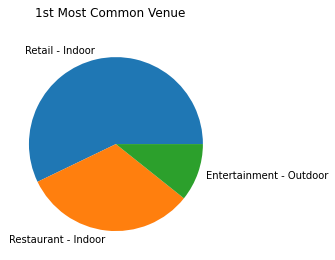

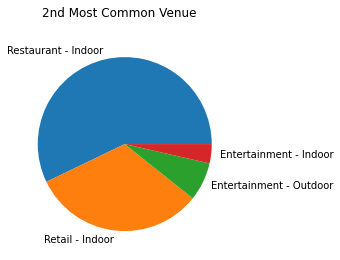

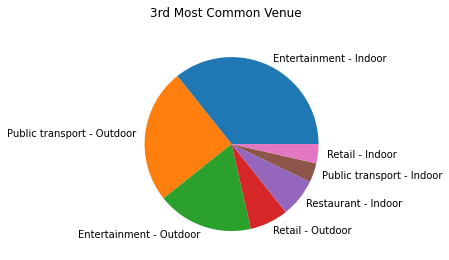

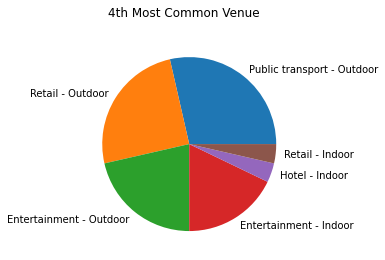

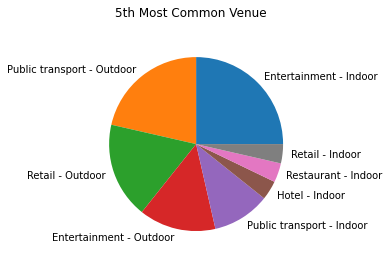

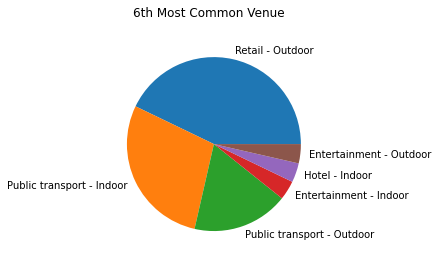

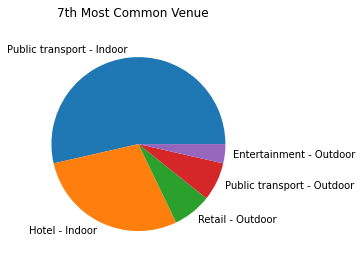

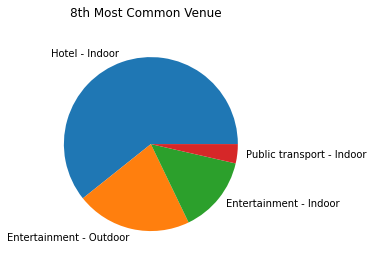

In [42]:
import matplotlib.pyplot as plt
print('Most common venues in neighbourhoods with high positivity rate:')
subplotnum = 0
spos=0
for colname in SV_sorted.columns:  
    if (colname != 'Neighborhood'):
        fig = plt.figure(subplotnum)
        SV_sorted[colname].value_counts().plot(kind='pie', title=colname, subplots=True, ylabel='')
        subplotnum += 1

### K-Means clustering for neighborhoods with high positvity rate

In [43]:
# set number of clusters
kclusters = 5

SV_clustering = SV_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SV_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 1, 3, 2, 0, 0, 0, 0], dtype=int32)

In [44]:
# add clustering labels
SV_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [45]:
SV_merged = df_selV.loc[df_selV['LocationCategory'] == "7-day pos >= 5%"].copy()

# # merge SV_top_grouped with df_SelV to add latitude/longitude for each neighborhood
SV_merged = SV_merged.join(SV_sorted.set_index('Neighborhood'), on='Neighborhood')

SV_merged.head() # check the last columns!

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,10308,Great Kills,7.42,1064,79,583.5,Yes,Staten Island,40.549480,-74.149324,7-day pos >= 5%,0,Restaurant - Indoor,Retail - Indoor,Public transport - Outdoor,Entertainment - Indoor,Retail - Outdoor,Public transport - Indoor,Hotel - Indoor,Entertainment - Outdoor
1,11697,Breezy Point,7.14,336,24,1414.8,Yes,Queens,40.557401,-73.925512,7-day pos >= 5%,1,Entertainment - Outdoor,Restaurant - Indoor,Retail - Outdoor,Retail - Indoor,Public transport - Outdoor,Public transport - Indoor,Hotel - Indoor,Entertainment - Indoor
2,10452,Concourse,6.37,1900,121,380.3,Yes,Bronx,40.834284,-73.915589,7-day pos >= 5%,2,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Public transport - Outdoor,Hotel - Indoor,Retail - Outdoor,Public transport - Indoor,Entertainment - Outdoor
3,11421,Woodhaven,6.30,1080,68,379.5,Yes,Queens,40.689887,-73.858110,7-day pos >= 5%,0,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Retail - Outdoor,Public transport - Indoor,Entertainment - Outdoor,Public transport - Outdoor,Hotel - Indoor
4,10306,New Dorp,6.28,2102,132,668.5,Yes,Staten Island,40.572572,-74.116479,7-day pos >= 5%,0,Retail - Indoor,Restaurant - Indoor,Public transport - Outdoor,Entertainment - Indoor,Entertainment - Outdoor,Retail - Outdoor,Public transport - Indoor,Hotel - Indoor


In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SV_merged['Latitude'], SV_merged['Longitude'], SV_merged['Neighborhood'], SV_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [47]:
df_ClusterSummary = pd.DataFrame(columns=['Max-pos-percent','Min-pos-percent', 'Max-NewPos', 'Min-NewPos', '1st Most Common Venue','2nd Most Common Venue',
                                          '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue'])

def ClusterAnalyser(df_CurCluster):
    cluster_row = {'Max-pos-percent': df_CurCluster['Pos-percent-7d'].max(),
                   'Min-pos-percent': df_CurCluster['Pos-percent-7d'].min(),
                   'Max-NewPos': df_CurCluster['NewPos'].max(),
                   'Min-NewPos': df_CurCluster['NewPos'].min(),
                   '1st Most Common Venue': df_CurCluster['1st Most Common Venue'].mode().to_string(header=False,index=False).strip(),
                   '2nd Most Common Venue': df_CurCluster['2nd Most Common Venue'].mode().to_string(header=False,index=False).strip(),
                   '3rd Most Common Venue': df_CurCluster['3rd Most Common Venue'].mode().to_string(header=False,index=False).strip(),
                   '4th Most Common Venue': df_CurCluster['4th Most Common Venue'].mode().to_string(header=False,index=False).strip(),
                   '5th Most Common Venue': df_CurCluster['5th Most Common Venue'].mode().to_string(header=False,index=False).strip()                   
                }
    #cluster_row
    return cluster_row

df_cluster1 = SV_merged.loc[SV_merged['Cluster Labels'] == 0, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummary = df_ClusterSummary.append (ClusterAnalyser(df_cluster1), ignore_index=True)

df_cluster2 = SV_merged.loc[SV_merged['Cluster Labels'] == 1, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummary = df_ClusterSummary.append (ClusterAnalyser(df_cluster2), ignore_index=True)

df_cluster3 = SV_merged.loc[SV_merged['Cluster Labels'] == 2, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummary = df_ClusterSummary.append (ClusterAnalyser(df_cluster3), ignore_index=True)

df_cluster4 = SV_merged.loc[SV_merged['Cluster Labels'] == 3, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummary = df_ClusterSummary.append (ClusterAnalyser(df_cluster3), ignore_index=True)

df_cluster5 = SV_merged.loc[SV_merged['Cluster Labels'] == 4, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummary = df_ClusterSummary.append (ClusterAnalyser(df_cluster4), ignore_index=True)

df_ClusterSummary.head()

,Max-pos-percent,Min-pos-percent,Max-NewPos,Min-NewPos,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,7.42,5.18,132,21,Retail - Indoor,Restaurant - Indoor,Entertainment - Indoor,Entertainment - Indoor\n Public transport - Ou...,Entertainment - Indoor
1,7.14,5.52,56,24,Entertainment - Outdoor,Restaurant - Indoor,Public transport - Outdoor\n Retail ...,Retail - Indoor\n Retail - Outdoor,Public transport - Outdoor\n Retail...
2,6.37,5.40,132,21,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor\n Public transport - Ou...,Public transport - Outdoor,Entertainment - Indoor
3,6.37,5.40,132,21,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor\n Public transport - Ou...,Public transport - Outdoor,Entertainment - Indoor
4,5.65,5.25,126,65,Retail - Indoor,Restaurant - Indoor,Entertainment - Outdoor,Retail - Outdoor,Public transport - Outdoor


## 6. Analyse neighborhoods with 7-day pos <= 1.5%

In [48]:
df_VwLowP = df_V_nearSV.loc[df_V_nearSV['Loc Cat'] == '7-day pos <= 1.5%'].copy()
df_VwLowP.head()
df_VwLowP.shape

(4107, 11)

In [49]:
# one hot encoding
SV_onehot = pd.get_dummies(df_VwLowP[['Type_In_Out']], prefix="", prefix_sep="")

# add Loc Cat column back to dataframe
#SV_onehot['Venue Type'] = df_V_nearSV['Venue Type'] 
#SV_onehot['Loc Cat'] = df_V_nearSV['Loc Cat'] 
SV_onehot['Neighborhood'] = df_VwLowP['Neighborhood'] 

# move Loc Cat column to the first column
fixed_columns = [SV_onehot.columns[-1]] + list(SV_onehot.columns[:-1])
SV_onehot = SV_onehot[fixed_columns]
                                                                                          
SV_onehot.head()

,Neighborhood,Entertainment - Both,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Public transport - Indoor,Public transport - Outdoor,Restaurant - Indoor,Retail - Indoor,Retail - Outdoor
1412,Roosevelt Island,0,0,1,0,0,0,0,0,0
1413,Roosevelt Island,0,0,1,0,0,0,0,0,0
1414,Roosevelt Island,0,1,0,0,0,0,0,0,0
1415,Roosevelt Island,0,0,0,0,0,0,1,0,0
1416,Roosevelt Island,0,0,0,0,0,0,0,0,1


In [50]:
SV_onehot.shape

(4107, 10)

In [51]:
SV_grouped = SV_onehot.groupby('Neighborhood').mean().reset_index()
SV_grouped

,Neighborhood,Entertainment - Both,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Public transport - Indoor,Public transport - Outdoor,Restaurant - Indoor,Retail - Indoor,Retail - Outdoor
0,Boerum Hill,0.00,0.190000,0.040000,0.000000,0.000000,0.000000,0.420000,0.350000,0.000000
1,Brooklyn Heights,0.00,0.200000,0.110000,0.020000,0.000000,0.000000,0.390000,0.270000,0.010000
2,Carroll Gardens,0.00,0.130000,0.040000,0.000000,0.000000,0.000000,0.430000,0.390000,0.010000
3,Chelsea,0.00,0.253623,0.057971,0.028986,0.000000,0.021739,0.268116,0.362319,0.000000
4,City Island,0.00,0.085106,0.191489,0.000000,0.000000,0.000000,0.425532,0.297872,0.000000
5,Clinton Hill,0.00,0.130000,0.090000,0.000000,0.000000,0.000000,0.500000,0.270000,0.010000
6,Cobble Hill,0.00,0.110000,0.040000,0.000000,0.000000,0.000000,0.460000,0.390000,0.000000
7,East Village,0.00,0.050000,0.030000,0.000000,0.000000,0.000000,0.560000,0.360000,0.000000
8,Financial District,0.00,0.150000,0.100000,0.040000,0.000000,0.010000,0.410000,0.270000,0.010000
9,Flatiron,0.00,0.190000,0.000000,0.020000,0.000000,0.000000,0.430000,0.340000,0.010000


In [52]:
# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 9

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
SV_sorted = pd.DataFrame(columns=columns)
SV_sorted['Neighborhood'] = SV_grouped['Neighborhood']

for ind in np.arange(SV_grouped.shape[0]):
    SV_sorted.iloc[ind, 1:] = return_most_common_venues(SV_grouped.iloc[ind, :], num_top_venues)

SV_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Boerum Hill,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Hotel - Indoor,Entertainment - Both
1,Brooklyn Heights,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Entertainment - Both
2,Carroll Gardens,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Hotel - Indoor,Entertainment - Both
3,Chelsea,Retail - Indoor,Restaurant - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Public transport - Outdoor,Retail - Outdoor,Public transport - Indoor,Entertainment - Both
4,City Island,Restaurant - Indoor,Retail - Indoor,Entertainment - Outdoor,Entertainment - Indoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Hotel - Indoor,Entertainment - Both


### Get most common venues

Most common venues in neighbourhoods with low positivity rate:


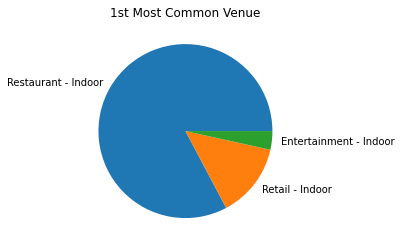

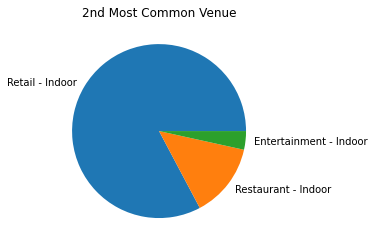

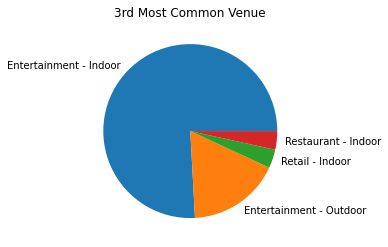

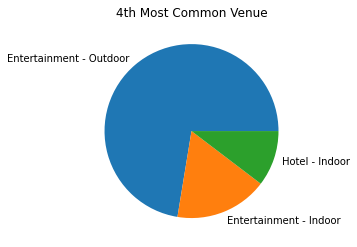

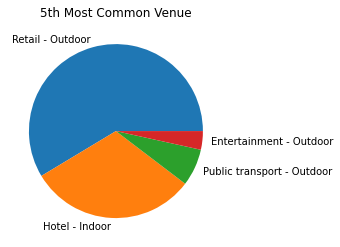

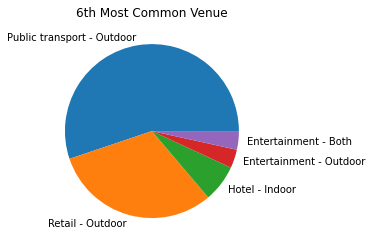

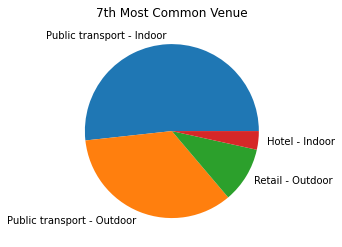

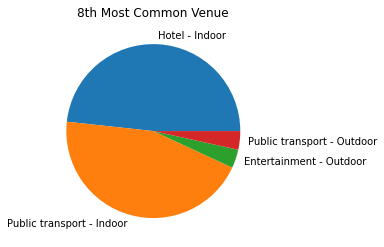

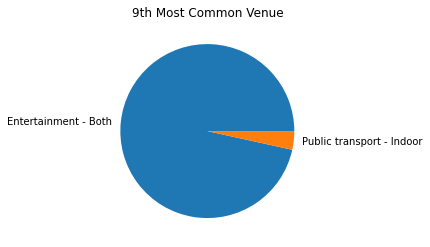

In [53]:
print('Most common venues in neighbourhoods with low positivity rate:')
subplotnum = 0
spos=0
for colname in SV_sorted.columns:  
    if (colname != 'Neighborhood'):
        fig = plt.figure(subplotnum)
        SV_sorted[colname].value_counts().plot.pie(title=colname, ylabel='')
        subplotnum += 1

### K-Means clustering for neighborhoods with low positvity rate

In [54]:
# set number of clusters
kclusters = 5

SV_clustering = SV_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SV_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 2, 1, 3, 0, 3, 1, 0], dtype=int32)

In [55]:
# add clustering labels
SV_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [56]:
SV_merged = df_selV.loc[df_selV['LocationCategory'] == "7-day pos <= 1.5%"].copy()


# # merge SV_top_grouped with df_SelV to add latitude/longitude for each neighborhood
SV_merged = SV_merged.join(SV_sorted.set_index('Neighborhood'), on='Neighborhood')

SV_merged.head() # check the last columns!

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
31,10044,Roosevelt Island,0.27,364,1,565.5,Yes,Manhattan,40.762160,-73.949168,7-day pos <= 1.5%,1,Restaurant - Indoor,Entertainment - Indoor,Retail - Indoor,Entertainment - Outdoor,Retail - Outdoor,Public transport - Outdoor,Hotel - Indoor,Public transport - Indoor,Entertainment - Both
32,10005,Financial District,0.48,414,2,753.7,Yes,Manhattan,40.707107,-74.010665,7-day pos <= 1.5%,1,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Entertainment - Both
33,10065,Lenox Hill,0.63,1912,12,1236.6,Yes,Manhattan,40.768113,-73.958860,7-day pos <= 1.5%,3,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Entertainment - Both
34,10065,Upper East Side,0.63,1912,12,1236.6,Yes,Manhattan,40.775639,-73.960508,7-day pos <= 1.5%,1,Restaurant - Indoor,Retail - Indoor,Entertainment - Outdoor,Entertainment - Indoor,Hotel - Indoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Entertainment - Both
35,10012,Greenwich Village,0.89,2139,19,1848.6,Yes,Manhattan,40.726933,-73.999914,7-day pos <= 1.5%,3,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Hotel - Indoor,Entertainment - Outdoor,Retail - Outdoor,Public transport - Outdoor,Public transport - Indoor,Entertainment - Both


In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SV_merged['Latitude'], SV_merged['Longitude'], SV_merged['Neighborhood'], SV_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [58]:
df_ClusterSummaryLow = pd.DataFrame(columns=['Max-pos-percent','Min-pos-percent', 'Max-NewPos', 'Min-NewPos', '1st Most Common Venue','2nd Most Common Venue',
                                          '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue'])
df_cluster1 = SV_merged.loc[SV_merged['Cluster Labels'] == 0, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummaryLow = df_ClusterSummaryLow.append (ClusterAnalyser(df_cluster1), ignore_index=True)

df_cluster2 = SV_merged.loc[SV_merged['Cluster Labels'] == 1, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummaryLow = df_ClusterSummaryLow.append (ClusterAnalyser(df_cluster2), ignore_index=True)

df_cluster3 = SV_merged.loc[SV_merged['Cluster Labels'] == 2, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummaryLow = df_ClusterSummaryLow.append (ClusterAnalyser(df_cluster3), ignore_index=True)

df_cluster4 = SV_merged.loc[SV_merged['Cluster Labels'] == 3, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummaryLow = df_ClusterSummaryLow.append (ClusterAnalyser(df_cluster3), ignore_index=True)

df_cluster5 = SV_merged.loc[SV_merged['Cluster Labels'] == 4, SV_merged.columns[[1] + list(range(2, SV_merged.shape[1]))]]
df_ClusterSummaryLow = df_ClusterSummaryLow.append (ClusterAnalyser(df_cluster4), ignore_index=True)

df_ClusterSummaryLow.head()

,Max-pos-percent,Min-pos-percent,Max-NewPos,Min-NewPos,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1.43,0.99,76,22,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Retail - Outdoor
1,1.50,0.27,41,1,Restaurant - Indoor,Retail - Indoor,Entertainment - Outdoor,Entertainment - Indoor,Hotel - Indoor
2,1.38,1.18,46,41,Retail - Indoor,Restaurant - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor
3,1.38,1.18,46,41,Retail - Indoor,Restaurant - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Hotel - Indoor
4,1.50,0.63,76,12,Restaurant - Indoor,Retail - Indoor,Entertainment - Indoor,Entertainment - Outdoor,Retail - Outdoor


## START -Not used Grouping venues at Top 10 positive case locations

In [46]:
SV_top_onehot = SV_onehot.loc[SV_onehot['Loc Cat'] == "Top 10 positive case"].copy()
SV_top_onehot.drop(columns='Loc Cat', inplace=True,)
SV_top_onehot.head()

,Neighborhood,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Bike Trail,Boat or Ferry,Bookstore,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,Colombian Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paintball Field,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bloomfield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bloomfield,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [47]:
SV_top_grouped = SV_top_onehot.groupby('Neighborhood').mean().reset_index()
SV_top_grouped

,Neighborhood,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Bike Trail,Boat or Ferry,Bookstore,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,Colombian Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paintball Field,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Annadale,0.100000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.050000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.050000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.05,0.050000,0.000000,0.000000,0.000000,0.050000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
SV_top_sorted = pd.DataFrame(columns=columns)
SV_top_sorted['Neighborhood'] = SV_top_grouped['Neighborhood']

for ind in np.arange(SV_top_grouped.shape[0]):
    SV_top_sorted.iloc[ind, 1:] = return_most_common_venues(SV_top_grouped.iloc[ind, :], num_top_venues)

SV_top_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,American Restaurant,Pizza Place,Trail,Restaurant,Park,Bus Stop,Chinese Restaurant,Bagel Shop,Train Station,Diner
1,Bloomfield,Baseball Field,Arcade,Pizza Place,Sporting Goods Shop,Park,Racetrack,Bus Stop,Bus Station,Burger Joint,Sports Club
2,Concourse,Fast Food Restaurant,Grocery Store,Deli / Bodega,Donut Shop,Park,Bar,Pizza Place,Gym,Chinese Restaurant,Spanish Restaurant
3,Elmhurst,Thai Restaurant,Bakery,Mexican Restaurant,Bubble Tea Shop,Indonesian Restaurant,Chinese Restaurant,South American Restaurant,Latin American Restaurant,Indian Restaurant,Food Truck
4,Lighthouse Hill,Italian Restaurant,History Museum,Bagel Shop,Golf Course,Cosmetics Shop,Spa,Park,Trail,Café,Pet Store


In [49]:
# set number of clusters
kclusters = 3

SV_top_clustering = SV_top_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SV_top_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

In [50]:
# add clustering labels
SV_top_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [51]:
SV_top_merged = df_selV.loc[df_selV['LocationCategory'] == "Top 10 positive case"].copy()

# # merge SV_top_grouped with df_SelV to add latitude/longitude for each neighborhood
SV_top_merged = SV_top_merged.join(SV_top_sorted.set_index('Neighborhood'), on='Neighborhood')

SV_top_merged.head() # check the last columns!

,ZIP,Neighborhood,Pos-percent-7d,NumTested,NewPos,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10314,Bloomfield,4.58,3337,153,612.8,Yes,Staten Island,40.605779,-74.187256,Top 10 positive case,1,Baseball Field,Arcade,Pizza Place,Sporting Goods Shop,Park,Racetrack,Bus Stop,Bus Station,Burger Joint,Sports Club
1,11230,Midwood,4.89,3106,152,492.7,Yes,Brooklyn,40.625596,-73.957595,Top 10 positive case,1,Pizza Place,Ice Cream Shop,Café,Sushi Restaurant,Bank,Bakery,Restaurant,Coffee Shop,Japanese Restaurant,Bagel Shop
2,10306,New Dorp,6.28,2102,132,668.5,Yes,Staten Island,40.572572,-74.116479,Top 10 positive case,1,Bank,Italian Restaurant,American Restaurant,Kids Store,Mexican Restaurant,Coffee Shop,Pizza Place,Bus Stop,Pharmacy,Discount Store
3,10306,Midland Beach,6.28,2102,132,668.5,Yes,Staten Island,40.573527,-74.093483,Top 10 positive case,1,Beach,Fast Food Restaurant,Baseball Field,Bus Stop,Pizza Place,Bagel Shop,Deli / Bodega,Cosmetics Shop,Pet Store,Asian Restaurant
4,10306,Lighthouse Hill,6.28,2102,132,668.5,Yes,Staten Island,40.576506,-74.137927,Top 10 positive case,2,Italian Restaurant,History Museum,Bagel Shop,Golf Course,Cosmetics Shop,Spa,Park,Trail,Café,Pet Store


In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SV_top_merged['Latitude'], SV_top_merged['Longitude'], SV_top_merged['Neighborhood'], SV_top_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [53]:
SV_top_merged.loc[SV_top_merged['Cluster Labels'] == 0, SV_top_merged.columns[[1] + list(range(5, SV_top_merged.shape[1]))]]

,Neighborhood,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Annadale,612.6,Yes,Staten Island,40.538114,-74.178549,Top 10 positive case,0,American Restaurant,Pizza Place,Trail,Restaurant,Park,Bus Stop,Chinese Restaurant,Bagel Shop,Train Station,Diner


In [54]:
SV_top_merged.loc[SV_top_merged['Cluster Labels'] == 1, SV_top_merged.columns[[1] + list(range(5, SV_top_merged.shape[1]))]]

,Neighborhood,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bloomfield,612.8,Yes,Staten Island,40.605779,-74.187256,Top 10 positive case,1,Baseball Field,Arcade,Pizza Place,Sporting Goods Shop,Park,Racetrack,Bus Stop,Bus Station,Burger Joint,Sports Club
1,Midwood,492.7,Yes,Brooklyn,40.625596,-73.957595,Top 10 positive case,1,Pizza Place,Ice Cream Shop,Café,Sushi Restaurant,Bank,Bakery,Restaurant,Coffee Shop,Japanese Restaurant,Bagel Shop
2,New Dorp,668.5,Yes,Staten Island,40.572572,-74.116479,Top 10 positive case,1,Bank,Italian Restaurant,American Restaurant,Kids Store,Mexican Restaurant,Coffee Shop,Pizza Place,Bus Stop,Pharmacy,Discount Store
3,Midland Beach,668.5,Yes,Staten Island,40.573527,-74.093483,Top 10 positive case,1,Beach,Fast Food Restaurant,Baseball Field,Bus Stop,Pizza Place,Bagel Shop,Deli / Bodega,Cosmetics Shop,Pet Store,Asian Restaurant
5,Oakwood,668.5,Yes,Staten Island,40.558462,-74.121566,Top 10 positive case,1,Asian Restaurant,Bus Stop,Bank,Burger Joint,Shipping Store,Sandwich Place,Restaurant,Coffee Shop,Playground,American Restaurant
7,Rossville,612.6,Yes,Staten Island,40.549404,-74.215729,Top 10 positive case,1,Bagel Shop,Donut Shop,Pizza Place,Liquor Store,Golf Course,Grocery Store,Food Truck,Event Space,Lounge,Dry Cleaner
8,Concourse,380.3,Yes,Bronx,40.834284,-73.915589,Top 10 positive case,1,Fast Food Restaurant,Grocery Store,Deli / Bodega,Donut Shop,Park,Bar,Pizza Place,Gym,Chinese Restaurant,Spanish Restaurant
9,Elmhurst,374.2,Yes,Queens,40.744049,-73.881656,Top 10 positive case,1,Thai Restaurant,Bakery,Mexican Restaurant,Bubble Tea Shop,Indonesian Restaurant,Chinese Restaurant,South American Restaurant,Latin American Restaurant,Indian Restaurant,Food Truck


In [55]:
SV_top_merged.loc[SV_top_merged['Cluster Labels'] == 2, SV_top_merged.columns[[1] + list(range(5, SV_top_merged.shape[1]))]]

,Neighborhood,DailyMedianTest-per100k,AdeqSample,Borough,Latitude,Longitude,LocationCategory,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Lighthouse Hill,668.5,Yes,Staten Island,40.576506,-74.137927,Top 10 positive case,2,Italian Restaurant,History Museum,Bagel Shop,Golf Course,Cosmetics Shop,Spa,Park,Trail,Café,Pet Store


## END -Not used 